### Getting data from kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amitlevizky","key":"8496db359317247ebfec0b7dcd9137b4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zaraks/pascal-voc-2007

100% 1.65G/1.65G [00:21<00:00, 96.9MB/s]
100% 1.65G/1.65G [00:21<00:00, 81.7MB/s]


In [ ]:
!ls

kaggle.json  pascal-voc-2007.zip  sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("pascal-voc-2007.zip", 'r')
zip_ref.extractall("files")
zip_ref.close()

**Plotting method for loss and PSNR metrics**

In [ ]:
from keras.layers import Dense
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plot_PSNR(history):
  psnr_str = get_psnr(history.history.keys())
  psnr_val_str = get_psnr_val(history.history.keys())
  plt.plot(history.history[psnr_str])
  plt.plot(history.history[psnr_val_str])
  plt.title('PSNR')
  plt.ylabel('PSNR')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def get_psnr(history_keys):
  for metric in history_keys:
    if 'PSNR' in metric and 'val' not in metric:
      return metric

def get_psnr_val(history_keys):
  for metric in history_keys:
    if 'PSNR' in metric and 'val' in metric:
      return metric

Using TensorFlow backend.


In [ ]:
def plot_impages(train_gen_72, train_gen_144, train_gen_288, preds_model):
  f1, axarr1 = plt.subplots(nrows=1, ncols=3, figsize=(20,16), squeeze=False)
  f2, axarr2 = plt.subplots(nrows=1, ncols=2, figsize=(14,7), squeeze=False)

  axarr1[0,0].imshow(train_gen_72[0][0])
  axarr1[0,1].imshow(train_gen_144[0][0])
  axarr1[0,2].imshow(train_gen_288[0][0])

  axarr1[0,0].title.set_text('(72,72)')
  axarr1[0,1].title.set_text('(144,144)')
  axarr1[0,2].title.set_text('(288,288)')




  axarr2[0,0].imshow(preds_model[0][0])
  axarr2[0,1].imshow(preds_model[1][0])

  axarr2[0,0].title.set_text('(72,72)->(144,144)')
  axarr2[0,1].title.set_text('(72,72)->(288,288)')

###Preparring the data
we will need to use generator to load the data.
ImageDataGenerator will be for help here

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
# load all images in a directory
import numpy as np
from os import listdir
import cv2

train_path = "/content/files/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007"
test_path = "/content/files/VOCtest_06-Nov-2007/VOCdevkit/VOC2007"


# load all images in a directory
file_names = listdir(train_path)
file_names_100 = listdir(train_path)[:100] # loads only the first 100 images, just for simplicity

X_train_dims = (72,72)
y_mid_dims = (144,144)
y_large_dims = (288,288)

batch_size = 64

epochs = 15

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen_72 = data_generator.flow_from_directory(train_path + '/', classes=['JPEGImages'] ,shuffle=False, color_mode='rgb', target_size=X_train_dims, batch_size=batch_size, class_mode=None, subset='training')
train_gen_72_val = data_generator.flow_from_directory(train_path + '/', classes=['JPEGImages'] ,shuffle=False, color_mode='rgb', target_size=X_train_dims, batch_size=batch_size, class_mode=None, subset='validation')

train_gen_144 = data_generator.flow_from_directory(train_path + '/', classes=['JPEGImages'] ,shuffle=False, color_mode='rgb', target_size=y_mid_dims, batch_size=batch_size, class_mode=None, subset='training')
train_gen_144_val = data_generator.flow_from_directory(train_path + '/', classes=['JPEGImages'] ,shuffle=False, color_mode='rgb', target_size=y_mid_dims, batch_size=batch_size, class_mode=None, subset='validation')

train_gen_288 = data_generator.flow_from_directory(train_path + '/', classes=['JPEGImages'], shuffle=False, color_mode='rgb', target_size=y_large_dims, batch_size=batch_size, class_mode=None, subset='training')
train_gen_288_val = data_generator.flow_from_directory(train_path + '/', classes=['JPEGImages'], shuffle=False, color_mode='rgb', target_size=y_large_dims, batch_size=batch_size, class_mode=None, subset='validation')

def fit_generator(X, y_mid, y_large):
  while True:
    yield (X.next(), [y_mid.next(), y_large.next()])

def train_generator(train_gen, size=1):
  for sample in train_gen:
    yield [sample[i] for i in range(size)]

def reset_generators(gen):
  gen.reset()


Found 4009 images belonging to 1 classes.
Found 1002 images belonging to 1 classes.
Found 4009 images belonging to 1 classes.
Found 1002 images belonging to 1 classes.
Found 4009 images belonging to 1 classes.
Found 1002 images belonging to 1 classes.


###Models:
**1. build_model:** will return a basic model. The input to this model is an image of dimensions (72X72) and the output will be splitted for 2 new images:
1. image with dimensions of (144X144)
2. image with dimensionsof (288X288)

**2. build_residual_model:** will return a little more complex model than the previous model. The input to this model is an image of dimensions (72X72) and the will be splitted for 2:
1. image with dimensions of (144X144)
2. image with dimensionsof (288X288)

**3. build_deep_residual_model:** Same model as the previous one but this time with the addition of more residual blocks. The level of complexity of the model is increasing. The input to this model is an image of dimensions (72X72) and the output will be splitted for 2 new images:
1. image with dimensions of (144X144)
2. image with dimensionsof (288X288)

**4. build_dilation_model:** The model is based on the previous models that used residual block. In this model, we will replace the residual blocks with dilation blocks. When selected in dilation at intervals of 1, 2, and 4. Then, we will perform concatenation and proceed in a similar fashion to the previous model. The input to this model is an image of dimensions (72X72) and the output will be splitted for 2 new images:
1. image with dimensions of (144X144)
2. image with dimensionsof (288X288)

**5. build_dilation_vgg16_model:** In this model, we will use regular convolution layers instead of the dilation or residual layers. Also, we will use a pre-trained model, in our case, VGG16, when it is already trained on imagenet. We will do concatenation, from what we got from the convolution and the trained model, and continue as in the previous models. The input to this model is an image of dimensions (72X72) and the output will be splitted for 2 new images:
1. image with dimensions of (144X144)
2. image with dimensionsof (288X288)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model_vgg_16 = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))
model_vgg_16_layer = model_vgg_16.get_layer("block1_conv2").output


58892288/58889256 [==============================] - 0s 0us/step


###imports and helper methods

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, add, Add, Concatenate
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.applications.vgg16 import VGG16
from keras import backend as K




def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def n_samples(gen, size):
  for x in train_gen_72:
      yield [x[i] for i in range(size)]



**Compiling the first model**

initial fully convolutional

In [ ]:
# initial fully convolutional
def build_model():
  input1 = Input(shape=(None, None, 3))
  x = (Conv2D(64, (3, 3), activation='relu', padding='same'))(input1)
  x = (Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
  x = (UpSampling2D((2,2)))(x)
  output2 = (UpSampling2D((2,2)))(x)
  output2 = (Conv2D(3, 1, activation='relu', padding='same'))(output2)
  x = (Conv2D(3, 1, activation='relu', padding='same'))(x)
  return Model(inputs=input1, outputs=[x, output2])


model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=[PSNR])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

**Fitting the first model, plot the loss and reset the generators**

In [ ]:
history_1 = model.fit_generator(fit_generator(train_gen_72, train_gen_144, train_gen_288),
                              steps_per_epoch=train_gen_72.samples // batch_size,
                              validation_data = fit_generator(train_gen_72_val, train_gen_144_val, train_gen_288_val),
                              validation_steps = train_gen_72_val.samples // batch_size,
                              epochs = epochs)

reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
62/62 [==============================] - 58s 928ms/step - loss: 0.1065 - conv2d_3_loss: 0.0475 - conv2d_2_loss: 0.0590 - conv2d_3_PSNR: inf - conv2d_2_PSNR: inf - val_loss: 0.0246 - val_conv2d_3_loss: 0.0122 - val_conv2d_2_loss: 0.0124 - val_conv2d_3_PSNR: inf - val_conv2d_2_PSNR: inf
Epoch 2/15
62/62 [==============================] - 58s 936ms/step - loss: 0.0220 - conv2d_3_loss: 0.0110 - conv2d_2_loss: 0.0110 - conv2d_3_PSNR: inf - conv2d_2_PSNR: inf - val_loss: 0.0209 - val_conv2d_3_loss: 0.0104 - val_conv2d_2_loss: 0.0104 - val_conv2d_3_PSNR: inf - val_conv2d_2_PSNR: 29.6665
Epoch 3/15
62/62 [==============================] - 58s 938ms/step - loss: 0.0207 - conv2d_3_loss: 0.0103 - conv2d_2_loss: 0.0103 - conv2d_3_PSNR: inf - conv2d_2_PSNR: 29.9126 - val_loss: 0.0204 - val_conv2d_3_loss: 0.0102 - val_conv2d_2_loss: 0.0102 - val_conv2d_3_PSNR: inf - val_conv2d_2_PSNR: 30.0358
Epoch 4/15
62/62 [===

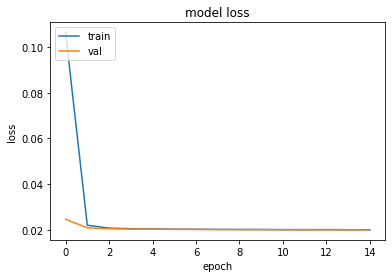

In [ ]:
#plot loss metrics
plot_loss(history_1)

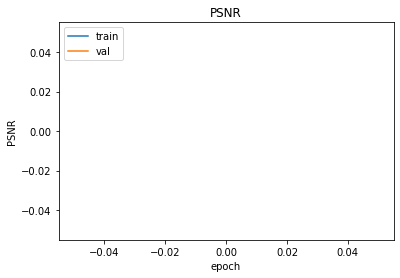

In [ ]:
#plot PSNR metrics
plot_PSNR(history_1)

In [ ]:
images_100 = np.asarray(next(n_samples(train_gen_72, 64)))

preds_model_1 = model.predict_generator(images_100)

Instructions for updating:
Please use Model.predict, which supports generators.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


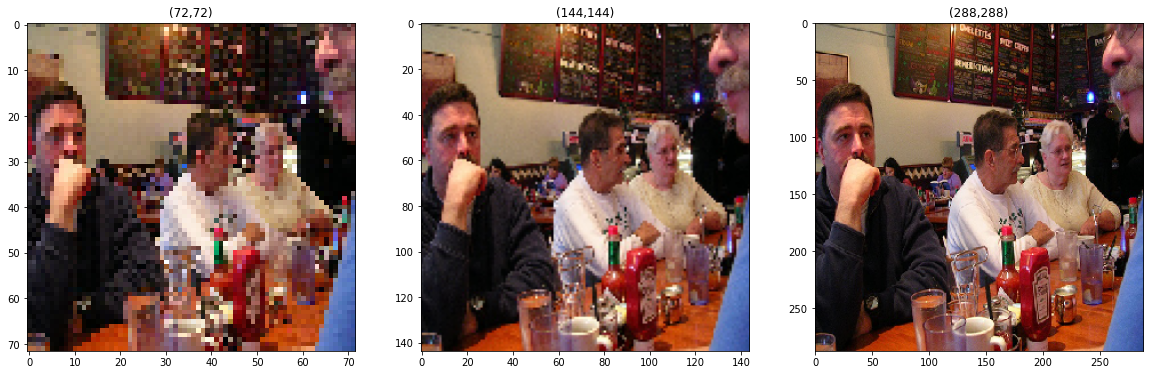

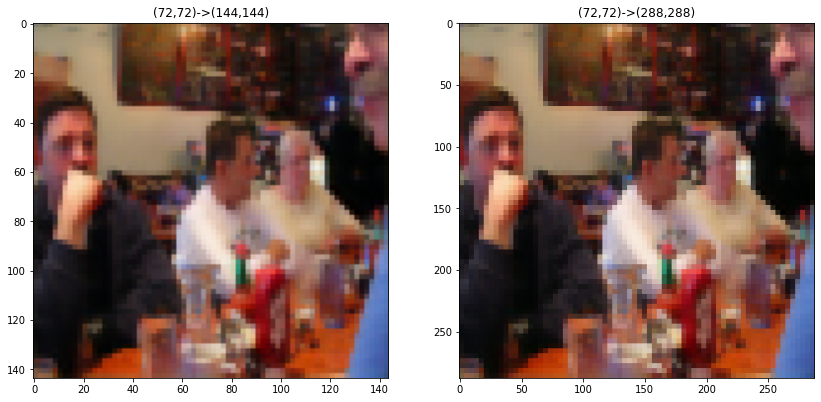

In [ ]:
#plot images and predictions
plot_impages(train_gen_72, train_gen_144, train_gen_288, preds_model_1)

**Compiling the second model (with residual layers)**



In [ ]:
def residual_block(cnl):
  inp = Input(shape=(None, None, cnl))
  x = Conv2D(cnl, 3, padding='same', activation=LeakyReLU(0.2))(inp)
  x = Conv2D(cnl, 3, padding='same', activation=LeakyReLU(0.2))(x)
  x = Add()([inp, x])
  output = Activation(LeakyReLU(0.2))(x)
  return Model(inp, output)


def build_residual_model():
  input1 = Input(shape=(None, None, 3))
  x = Conv2D(32, 3, activation=LeakyReLU(0.2), padding='same')(input1)
  x = residual_block(32)(x)
  x = residual_block(32)(x)
  x = UpSampling2D()(x)
  y = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
  x = residual_block(32)(x)
  x = UpSampling2D()(x)
  y2 = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
  return Model(inputs=input1, outputs=[y, y2])

# model with residual blocks
model = build_residual_model()
model.compile(optimizer='adam', loss='mse', metrics=[PSNR])
model.summary()

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, None, None, 3 896         input_51[0][0]                   
__________________________________________________________________________________________________
model_42 (Model)                (None, None, None, 3 18496       conv2d_171[0][0]                 
__________________________________________________________________________________________________
model_43 (Model)                (None, None, None, 3 18496       model_42[1][0]                   
___________________________________________________________________________________________

**Fitting the second model, plot the loss and reset the generators**

In [ ]:
reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

history_2_residual = model.fit_generator(fit_generator(train_gen_72, train_gen_144, train_gen_288),
                              steps_per_epoch=train_gen_72.samples // batch_size,
                              validation_data = fit_generator(train_gen_72_val, train_gen_144_val, train_gen_288_val),
                              validation_steps = train_gen_72_val.samples // batch_size,
                              epochs = epochs)

reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

Epoch 1/15
62/62 [==============================] - 75s 1s/step - loss: 0.0538 - conv2d_176_loss: 0.0284 - conv2d_179_loss: 0.0254 - conv2d_176_PSNR: 20.5791 - conv2d_179_PSNR: 21.2466 - val_loss: 0.0263 - val_conv2d_176_loss: 0.0135 - val_conv2d_179_loss: 0.0128 - val_conv2d_176_PSNR: 24.6935 - val_conv2d_179_PSNR: 25.4509
Epoch 2/15
62/62 [==============================] - 76s 1s/step - loss: 0.0245 - conv2d_176_loss: 0.0126 - conv2d_179_loss: 0.0119 - conv2d_176_PSNR: 25.7028 - conv2d_179_PSNR: 26.2487 - val_loss: 0.0234 - val_conv2d_176_loss: 0.0120 - val_conv2d_179_loss: 0.0114 - val_conv2d_176_PSNR: 26.0880 - val_conv2d_179_PSNR: 26.6059
Epoch 3/15
62/62 [==============================] - 75s 1s/step - loss: 0.0227 - conv2d_176_loss: 0.0117 - conv2d_179_loss: 0.0110 - conv2d_176_PSNR: 26.5548 - conv2d_179_PSNR: 26.8845 - val_loss: 0.0218 - val_conv2d_176_loss: 0.0113 - val_conv2d_179_loss: 0.0105 - val_conv2d_176_PSNR: 27.1622 - val_conv2d_179_PSNR: 27.7341
Epoch 4/15
62/62 [====

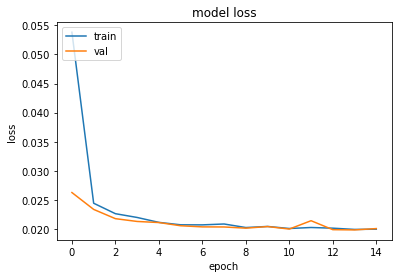

In [ ]:
#plot loss metrics
plot_loss(history_2_residual)

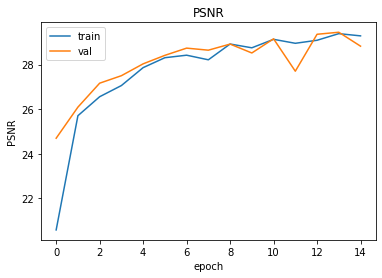

In [ ]:
#plot PSNR metrics
plot_PSNR(history_2_residual)

In [ ]:
images_100 = np.asarray(next(n_samples(train_gen_72, 64)))

preds_model_2 = model.predict_generator(images_100)

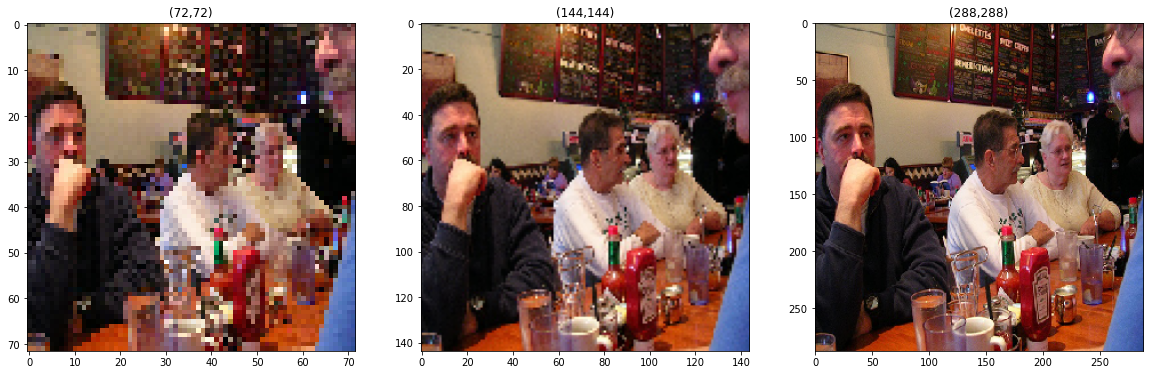

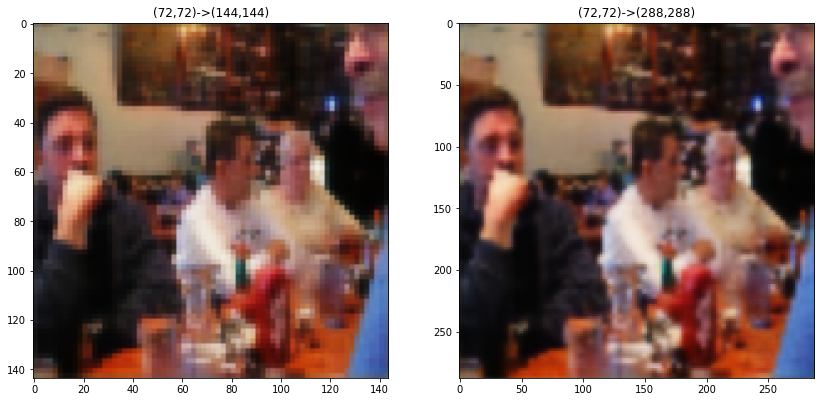

In [ ]:
plot_impages(train_gen_72, train_gen_144, train_gen_288, preds_model_2)

In [ ]:
def build_deep_residual_model():
  input1 = Input(shape=(None, None, 3))
  x = Conv2D(32, 3, activation=LeakyReLU(0.2), padding='same')(input1)
  x = residual_block(32)(x)
  x = residual_block(32)(x)
  x = residual_block(32)(x)
  x = residual_block(32)(x)
  x = residual_block(32)(x)
  x = residual_block(32)(x)
  x = UpSampling2D()(x)
  y = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
  x = residual_block(32)(x)
  x = UpSampling2D()(x)
  y2 = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
  return Model(inputs=input1, outputs=[y, y2])

model = build_deep_residual_model()
model.compile(optimizer='adam', loss='mse', metrics=[PSNR])
model.summary()

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, None, None, 3 896         input_55[0][0]                   
__________________________________________________________________________________________________
model_46 (Model)                (None, None, None, 3 18496       conv2d_180[0][0]                 
__________________________________________________________________________________________________
model_47 (Model)                (None, None, None, 3 18496       model_46[1][0]                   
___________________________________________________________________________________________

In [ ]:
reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

history_3_residual_deeper = model.fit_generator(fit_generator(train_gen_72, train_gen_144, train_gen_288),
                              steps_per_epoch=train_gen_72.samples // batch_size,
                              validation_data = fit_generator(train_gen_72_val, train_gen_144_val, train_gen_288_val),
                              validation_steps = train_gen_72_val.samples // batch_size,
                              epochs = epochs)

reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

Epoch 1/15
62/62 [==============================] - 79s 1s/step - loss: 0.0615 - conv2d_193_loss: 0.0330 - conv2d_196_loss: 0.0285 - conv2d_193_PSNR: 20.0249 - conv2d_196_PSNR: 20.8726 - val_loss: 0.0262 - val_conv2d_193_loss: 0.0136 - val_conv2d_196_loss: 0.0126 - val_conv2d_193_PSNR: 24.7811 - val_conv2d_196_PSNR: 25.1942
Epoch 2/15
62/62 [==============================] - 79s 1s/step - loss: 0.0243 - conv2d_193_loss: 0.0125 - conv2d_196_loss: 0.0118 - conv2d_193_PSNR: 25.7717 - conv2d_196_PSNR: 25.8927 - val_loss: 0.0228 - val_conv2d_193_loss: 0.0117 - val_conv2d_196_loss: 0.0110 - val_conv2d_193_PSNR: 26.4592 - val_conv2d_196_PSNR: 26.6895
Epoch 3/15
62/62 [==============================] - 78s 1s/step - loss: 0.0228 - conv2d_193_loss: 0.0117 - conv2d_196_loss: 0.0112 - conv2d_193_PSNR: 26.6323 - conv2d_196_PSNR: 26.6769 - val_loss: 0.0220 - val_conv2d_193_loss: 0.0113 - val_conv2d_196_loss: 0.0107 - val_conv2d_193_PSNR: 26.9156 - val_conv2d_196_PSNR: 27.2118
Epoch 4/15
62/62 [====

In [ ]:
images_100 = np.asarray(next(n_samples(train_gen_72, 64)))

# type(train_gen_72)
preds_model_3 = model.predict_generator(images_100)

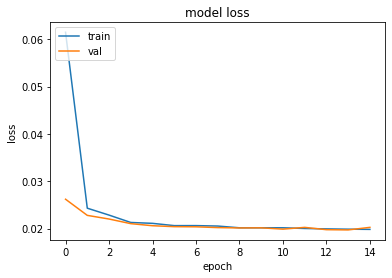

In [ ]:
#plot loss metrics
plot_loss(history_3_residual)

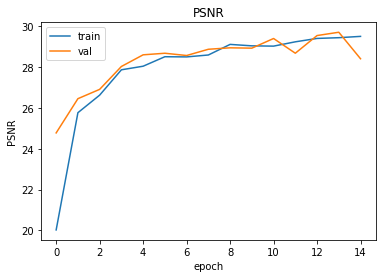

In [ ]:
#plot loss metrics
plot_PSNR(history_3_residual)

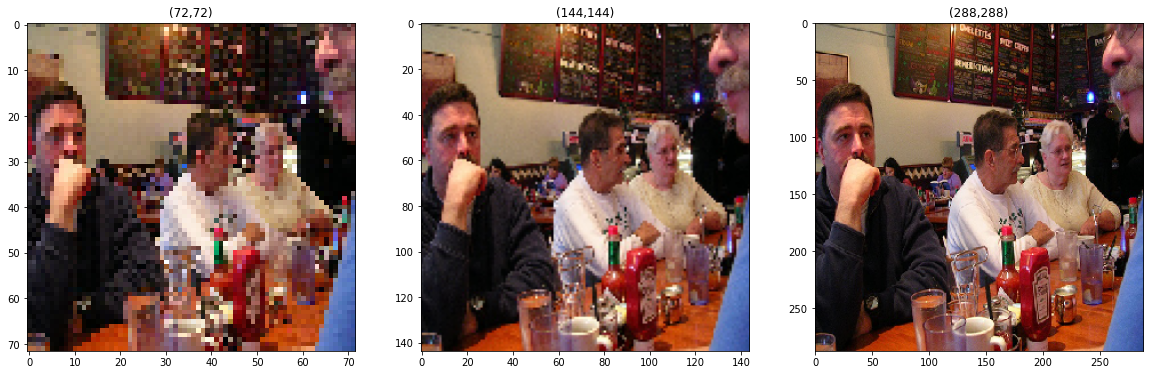

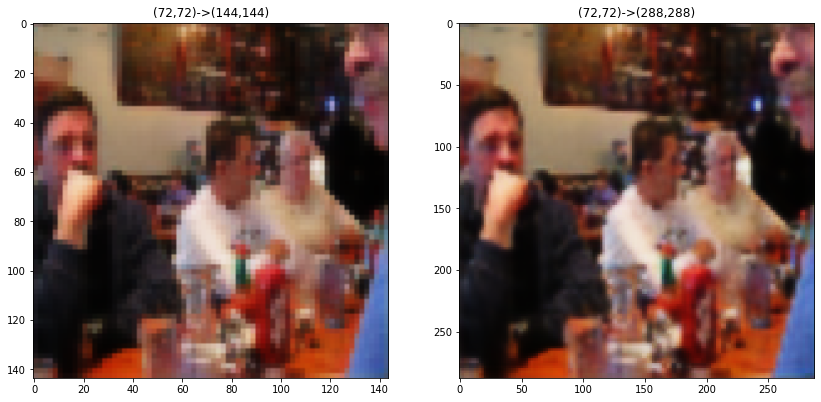

In [ ]:
plot_impages(train_gen_72, train_gen_144, train_gen_288, preds_model_3)

In [ ]:
def dilation_block(cnl):
  inp = Input(shape=(None, None, cnl))
  y1 = Conv2D(cnl, 3, padding='same', dilation_rate=(1,1), activation=LeakyReLU(0.2))(inp)
  y2 = Conv2D(cnl, 3, padding='same', dilation_rate=(2,2), activation=LeakyReLU(0.2))(inp)
  y4 = Conv2D(cnl, 3, padding='same', dilation_rate=(4,4), activation=LeakyReLU(0.2))(inp)
  x = Concatenate()([y1, y2, y4])
  x = Activation(LeakyReLU(0.2))(x)
  output = Conv2D(cnl, 3, padding='same', activation=LeakyReLU(0.2))(x)
  return Model(inp, output)

def build_dilation_model():
  input1 = Input(shape=(None, None, 3))
  x = Conv2D(32, 3, activation=LeakyReLU(0.2), padding='same')(input1)
  x = dilation_block(32)(x)
  x = dilation_block(32)(x)
  x = UpSampling2D()(x)
  y = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
  x = dilation_block(32)(x)
  x = UpSampling2D()(x)
  y2 = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
  return Model(inputs=input1, outputs=[y, y2])

model = build_dilation_model()
model.compile(optimizer='adam', loss='mse', metrics=[PSNR])
model.summary()

Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_197 (Conv2D)             (None, None, None, 3 896         input_63[0][0]                   
__________________________________________________________________________________________________
model_54 (Model)                (None, None, None, 3 55424       conv2d_197[0][0]                 
__________________________________________________________________________________________________
model_55 (Model)                (None, None, None, 3 55424       model_54[1][0]                   
___________________________________________________________________________________________

In [ ]:
reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

history_5_residual = model.fit_generator(fit_generator(train_gen_72, train_gen_144, train_gen_288),
                              steps_per_epoch=train_gen_72.samples // batch_size,
                              validation_data = fit_generator(train_gen_72_val, train_gen_144_val, train_gen_288_val),
                              validation_steps = train_gen_72_val.samples // batch_size,
                              epochs = epochs)

reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

Epoch 1/15
62/62 [==============================] - 88s 1s/step - loss: 0.0618 - conv2d_206_loss: 0.0319 - conv2d_211_loss: 0.0299 - conv2d_206_PSNR: 20.0833 - conv2d_211_PSNR: 20.5679 - val_loss: 0.0272 - val_conv2d_206_loss: 0.0139 - val_conv2d_211_loss: 0.0133 - val_conv2d_206_PSNR: 24.7092 - val_conv2d_211_PSNR: 25.1529
Epoch 2/15
62/62 [==============================] - 88s 1s/step - loss: 0.0254 - conv2d_206_loss: 0.0129 - conv2d_211_loss: 0.0124 - conv2d_206_PSNR: 25.4562 - conv2d_211_PSNR: 25.7373 - val_loss: 0.0235 - val_conv2d_206_loss: 0.0120 - val_conv2d_211_loss: 0.0115 - val_conv2d_206_PSNR: 26.3834 - val_conv2d_211_PSNR: 26.5794
Epoch 3/15
62/62 [==============================] - 88s 1s/step - loss: 0.0227 - conv2d_206_loss: 0.0116 - conv2d_211_loss: 0.0111 - conv2d_206_PSNR: 26.8054 - conv2d_211_PSNR: 27.1361 - val_loss: 0.0218 - val_conv2d_206_loss: 0.0112 - val_conv2d_211_loss: 0.0106 - val_conv2d_206_PSNR: 27.4537 - val_conv2d_211_PSNR: 27.9238
Epoch 4/15
62/62 [====

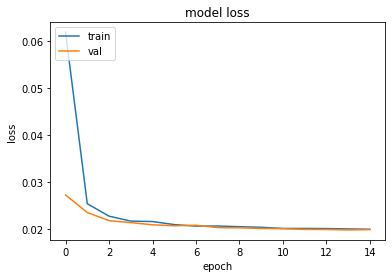

In [ ]:
#plot loss metrics
plot_loss(history_5_residual)

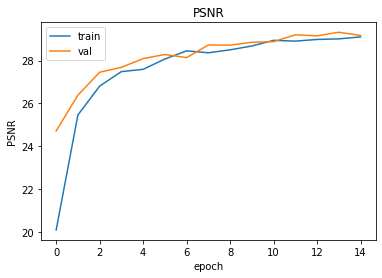

In [ ]:
#plot PNSR metrics
plot_PSNR(history_5_residual)

In [ ]:
images_100 = np.asarray(next(n_samples(train_gen_72, 64)))

# type(train_gen_72)
preds_model_5 = model.predict_generator(images_100)

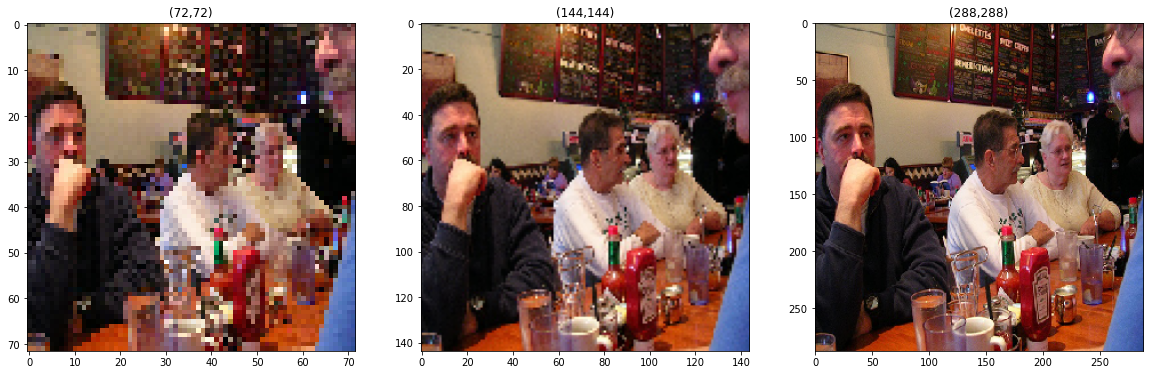

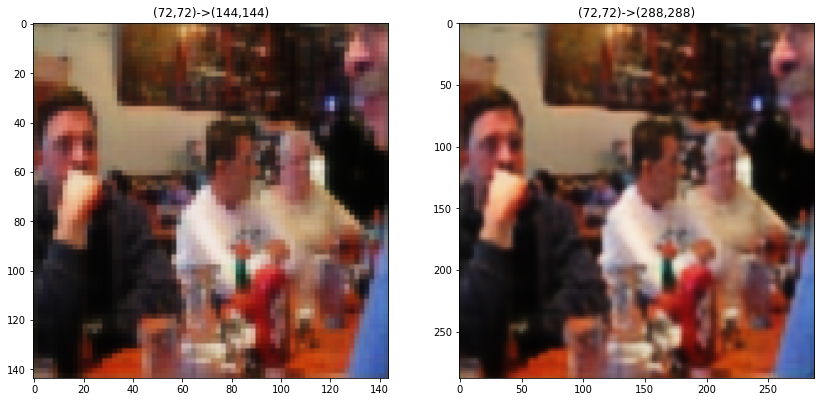

In [ ]:
plot_impages(train_gen_72, train_gen_144, train_gen_288, preds_model_5)

In [ ]:
def build_dilation_vgg16_model():
  input1 = Input(shape=(None, None, 3))
  model_vgg_16 = VGG16(include_top=False, weights='imagenet', input_tensor=input1)
  model_vgg_16_layer = model_vgg_16.get_layer('block1_conv2').output
  x = Conv2D(64, 3, activation=LeakyReLU(0.2), padding='same')(input1)
  x = Conv2D(64, 3, activation=LeakyReLU(0.2), padding='same')(x)
  # vgg_model = model_vgg_16(input1)
  # x = dilation_block(32)(x)
  # x = dilation_block(32)(x)
  x = Concatenate()([x, model_vgg_16_layer])
  x = UpSampling2D()(x)
  y = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
  # x = dilation_block(32)(x)
  x = UpSampling2D()(x)
  y2 = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
  x = Conv2D(3, 1, activation=LeakyReLU(0.2), padding='same')(x)
  return Model(inputs=input1, outputs=[y, y2])

model = build_dilation_vgg16_model()
model.compile(optimizer='adam', loss='mse', metrics=[PSNR])
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 6 36928       conv2d_4[0][0]                   
___________________________

In [ ]:
reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

history_6_residual = model.fit_generator(fit_generator(train_gen_72, train_gen_144, train_gen_288),
                              steps_per_epoch=train_gen_72.samples // batch_size,
                              validation_data = fit_generator(train_gen_72_val, train_gen_144_val, train_gen_288_val),
                              validation_steps = train_gen_72_val.samples // batch_size,
                              epochs = epochs)

reset_generators(train_gen_72)
reset_generators(train_gen_144)
reset_generators(train_gen_288)
reset_generators(train_gen_72_val)
reset_generators(train_gen_144_val)
reset_generators(train_gen_288_val)

Epoch 1/15
62/62 [==============================] - 62s 1s/step - loss: 0.0846 - conv2d_6_loss: 0.0424 - conv2d_7_loss: 0.0421 - conv2d_6_PSNR: 18.9698 - conv2d_7_PSNR: 19.3919 - val_loss: 0.0312 - val_conv2d_6_loss: 0.0158 - val_conv2d_7_loss: 0.0154 - val_conv2d_6_PSNR: 23.6014 - val_conv2d_7_PSNR: 23.7572
Epoch 2/15
62/62 [==============================] - 63s 1s/step - loss: 0.0272 - conv2d_6_loss: 0.0136 - conv2d_7_loss: 0.0136 - conv2d_6_PSNR: 24.8766 - conv2d_7_PSNR: 24.7401 - val_loss: 0.0248 - val_conv2d_6_loss: 0.0123 - val_conv2d_7_loss: 0.0125 - val_conv2d_6_PSNR: 25.9340 - val_conv2d_7_PSNR: 25.6004
Epoch 3/15
62/62 [==============================] - 63s 1s/step - loss: 0.0239 - conv2d_6_loss: 0.0119 - conv2d_7_loss: 0.0120 - conv2d_6_PSNR: 26.3690 - conv2d_7_PSNR: 26.1601 - val_loss: 0.0232 - val_conv2d_6_loss: 0.0116 - val_conv2d_7_loss: 0.0116 - val_conv2d_6_PSNR: 26.7787 - val_conv2d_7_PSNR: 26.6167
Epoch 4/15
62/62 [==============================] - 64s 1s/step - loss

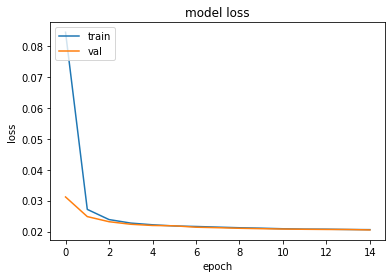

In [ ]:
#plot loss metrics
plot_loss(history_6_residual)

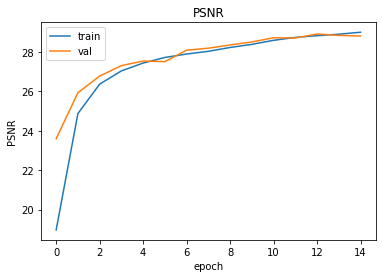

In [ ]:
#plot PSNR metrics
plot_PSNR(history_6_residual)

In [ ]:
images_100 = np.asarray(next(n_samples(train_gen_72, 64)))

# type(train_gen_72)
preds_model_6 = model.predict_generator(images_100)

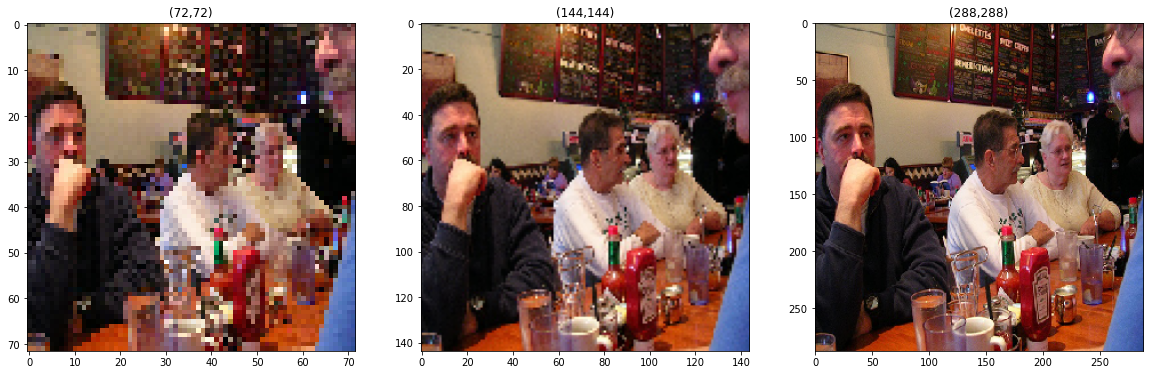

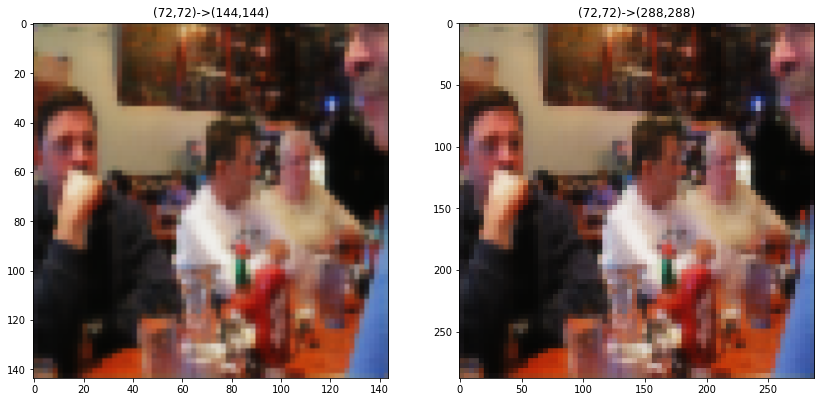

In [ ]:
plot_impages(train_gen_72, train_gen_144, train_gen_288, preds_model_6)